In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/MINI.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop(df2[(df2["Fiyat"] > 1500000)].index, axis=0, inplace=True)

In [4]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [5]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Cooper,Seri_Cooper Clubman,Seri_Cooper S,...,Model_1.6 D,Model_1.6 S,Model_2.0,Model_2.0 Works,Model_2.0 Works Iconic,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik
0,1400000,2020,116,1496,53000,NaN,NaN,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,377500,2006,120,1598,240000,NaN,NaN,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2,865000,2017,116,1496,99000,0.0,0.0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,325000,2005,115,1598,189000,NaN,NaN,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,420000,2008,175,1598,255000,NaN,NaN,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [6]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [9]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [10]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_11816\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,93164.308035,1.356962e+10,116488.716245,75586.289583


In [11]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:17:15,695] A new study created in memory with name: no-name-923ad0cf-e527-48af-8921-6362d451f125
[I 2023-10-08 14:17:15,814] Trial 0 finished with value: 644809.6952587405 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.0006890334690956057, 'max_depth': 6, 'min_child_weight': 21}. Best is trial 0 with value: 644809.6952587405.
[I 2023-10-08 14:17:15,814] Trial 3 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.004413255218078175, 'max_depth': 4, 'min_child_weight': 299}. Best is trial 0 with value: 644809.6952587405.
[I 2023-10-08 14:17:15,814] Trial 1 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3889186261365563, 'max_depth': 9, 'min_child_weight': 142}. Best is trial 0 with value: 644809.6952587405.
[I 2023-10-08 14:17:15,830] Trial 2 finished with value: 648825.3906318581 and parameters: {'colsam

[I 2023-10-08 14:17:16,868] Trial 30 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.0249305948961047, 'max_depth': 5, 'min_child_weight': 86}. Best is trial 27 with value: 502975.4771447024.
[I 2023-10-08 14:17:16,868] Trial 31 finished with value: 519729.32011419977 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.02579556270046115, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 27 with value: 502975.4771447024.
[I 2023-10-08 14:17:16,984] Trial 32 finished with value: 507509.82122972456 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.027627872746082, 'max_depth': 8, 'min_child_weight': 2}. Best is trial 27 with value: 502975.4771447024.
[I 2023-10-08 14:17:17,014] Trial 33 finished with value: 483304.4511421869 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.03321035886723304, 'max_depth': 8, 'min_child_weight': 5}. 

[I 2023-10-08 14:17:18,437] Trial 60 finished with value: 315582.03411679756 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.10104590339038724, 'max_depth': 10, 'min_child_weight': 39}. Best is trial 60 with value: 315582.03411679756.
[I 2023-10-08 14:17:18,437] Trial 61 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.08371852019268781, 'max_depth': 10, 'min_child_weight': 38}. Best is trial 60 with value: 315582.03411679756.
[I 2023-10-08 14:17:18,472] Trial 62 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.22048965561840975, 'max_depth': 11, 'min_child_weight': 99}. Best is trial 60 with value: 315582.03411679756.
[I 2023-10-08 14:17:18,493] Trial 63 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.09042258757713895, 'max_depth': 11, 'min_child_we

[I 2023-10-08 14:17:19,920] Trial 89 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.40734293844160196, 'max_depth': 14, 'min_child_weight': 229}. Best is trial 84 with value: 122736.78363077683.
[I 2023-10-08 14:17:19,938] Trial 90 finished with value: 127879.81698398432 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4031438283765328, 'max_depth': 14, 'min_child_weight': 9}. Best is trial 84 with value: 122736.78363077683.
[I 2023-10-08 14:17:20,161] Trial 92 finished with value: 253518.35505261415 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4370732057642344, 'max_depth': 13, 'min_child_weight': 28}. Best is trial 84 with value: 122736.78363077683.
[I 2023-10-08 14:17:20,196] Trial 94 finished with value: 253626.46503961983 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4646294424352541, 'max_depth': 13, 'min_child_wei

[I 2023-10-08 14:17:21,703] Trial 120 finished with value: 127364.21869933163 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.24054157947037508, 'max_depth': 15, 'min_child_weight': 2}. Best is trial 117 with value: 114526.73729959423.
[I 2023-10-08 14:17:21,830] Trial 121 finished with value: 174576.59955630027 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.49092173867512584, 'max_depth': 15, 'min_child_weight': 23}. Best is trial 117 with value: 114526.73729959423.
[I 2023-10-08 14:17:21,862] Trial 122 finished with value: 121541.00170294972 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.4969575740436638, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 117 with value: 114526.73729959423.
[I 2023-10-08 14:17:21,910] Trial 123 finished with value: 125609.12465041396 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.49445159639389036, 'max_depth': 15, 'min_c

[I 2023-10-08 14:17:23,598] Trial 150 finished with value: 153382.30786185426 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.19072875195451125, 'max_depth': 15, 'min_child_weight': 4}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:23,732] Trial 151 finished with value: 253114.43828091995 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.2123332232999541, 'max_depth': 15, 'min_child_weight': 35}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:23,842] Trial 153 finished with value: 142276.82445767807 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.20978629113959296, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:23,842] Trial 152 finished with value: 131544.46786860668 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.22373640862462255, 'max_depth': 15, 'min_c

[I 2023-10-08 14:17:25,724] Trial 182 finished with value: 115083.38472777145 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.34238622891900855, 'max_depth': 15, 'min_child_weight': 7}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:25,743] Trial 180 finished with value: 116687.35364248641 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3519731758933073, 'max_depth': 15, 'min_child_weight': 7}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:25,743] Trial 181 finished with value: 130279.48470586476 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3584164993175174, 'max_depth': 15, 'min_child_weight': 8}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:25,930] Trial 183 finished with value: 127142.6735053204 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3329163421489413, 'max_depth': 15, 'min_child

[I 2023-10-08 14:17:27,881] Trial 210 finished with value: 615943.6004065356 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.005616944103425245, 'max_depth': 15, 'min_child_weight': 19}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:27,942] Trial 211 finished with value: 604865.5111731204 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.007528929561773543, 'max_depth': 15, 'min_child_weight': 18}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:27,997] Trial 212 finished with value: 631903.529328959 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.0028664724270978737, 'max_depth': 15, 'min_child_weight': 18}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:28,074] Trial 213 finished with value: 114422.24670421213 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.31345496244060567, 'max_depth': 15, 'mi

[I 2023-10-08 14:17:30,241] Trial 242 finished with value: 120020.60948931528 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.29907196010014697, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:30,241] Trial 240 finished with value: 123654.5914900561 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.30623031689320246, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:30,241] Trial 241 finished with value: 123068.65806283095 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.29421984048202293, 'max_depth': 15, 'min_child_weight': 2}. Best is trial 130 with value: 109754.84325958425.
[I 2023-10-08 14:17:30,392] Trial 243 finished with value: 120215.18861149506 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.2972982016784419, 'max_depth': 14, 'min_chi

In [13]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 109754.8433
Best params:
	colsample_bytree: 0.9
	subsample: 0.7
	learning_rate: 0.38497168773722523
	max_depth: 15
	min_child_weight: 1


In [14]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 99514.64680030916, 'MSE': 12708354946.419075, 'RMSE': 112731.33968164786, 'MAE': 74002.60416666667}


In [15]:
r2 = r2_score(y_test, y_pred)
r2

0.7986183479467444

In [16]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.5712519665962945

In [17]:
marka_model = joblib.dump(final_model, "MINI.pkl")

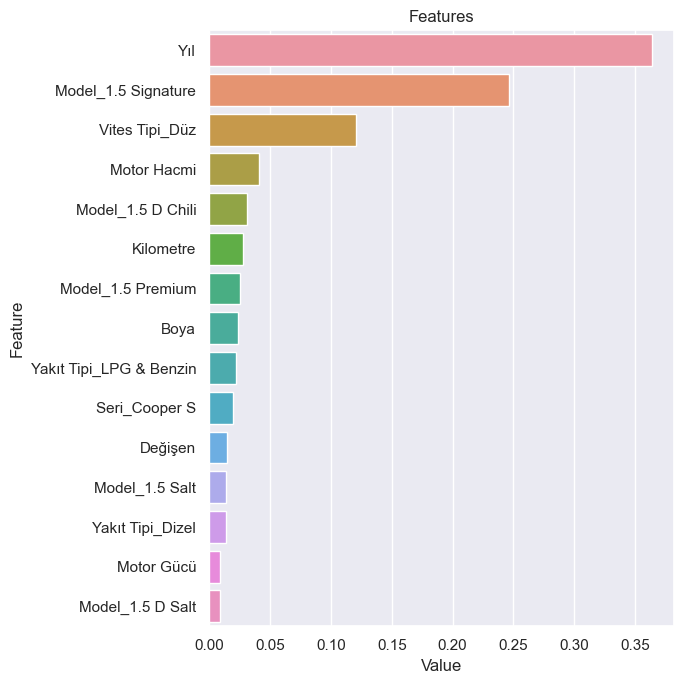

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)